# Motivation and Rationale

Inferring that a contributor's connectedness is a useful proxy for their importance
or involvement in a community, take the top p% of contributors 
by their pagerank score and identify which repos they also belong to.

Compare involvement to find maximal overlap among top percentage of contributors.

# Background

We've started from a 'seed' of repos that seem highly likely to be a "part of the WASM neighborhood of projects." We identified these few repos by \
cursorily inspecting online lists of WASM projects. The 'seed' includes (repo/org):

1. bytecodealliance/wasmtime
2. wasmedge/wasmedge
3. wasmerio/wasmer
4. wavm/wavm

## Imports

In [96]:
import pandas as pd
import sqlalchemy as salc
import plotly.express as px
import json
from IPython.display import Image
from collections import Counter

## Database

In [97]:
# read configuration file
with open("wasm_creds.json") as config_file:
    config = json.load(config_file)

# define cx string
database_connection_string = f"postgresql+psycopg2://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

# create engine
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': f"-csearch_path={'augur_data'}"})

## Global Switches

In [98]:
# Whether we're using df_event_stream.parquet or 
# querying the source database directly.
LOCAL_DATA = True 

# what percent of the top contributors 
# by pagerank should we consider?
TOP_PERCENT_CONSIDERED = 0.10 #10%

# how many "top repos" should we output 
# at the end?
FINAL_NUM_COMMON_REPOS = 50

## Read pagerank scores

These scores are calculated by building a collaboration graph of the contributors in four projects
and running the pagerank algorithm on the graph. The nodes of the graph are individual contributors,
and the edges are weighted by the historical 'connectedness' between any two nodes. Connectedness increases
when two individuals work on something together (PR, issue, commit). 

The described process is implemented in Rappel/notebooks/collab_network/wasm.

In [99]:
df_known_contribs = pd.read_csv('wasm_contributor_pagerank.csv')
df_known_contribs = df_known_contribs.rename(columns={"user": "cntrb_id"})
df_known_contribs["cntrb_id"] = df_known_contribs.cntrb_id.astype(str)
df_known_contribs.head()

,cntrb_id,score
0,010002df-6100-0000-0000-000000000000,20.000000
1,010000fd-e400-0000-0000-000000000000,19.052353
2,01002a5e-b400-0000-0000-000000000000,17.138503
3,0100034c-5400-0000-0000-000000000000,16.901099
4,01003291-1b00-0000-0000-000000000000,16.831682


# Contribution event stream

Github provides an API endpoint from which one can query every event that occurs. For instance, if a contributor creates an issue on some repo, that event will be logged in the stream. A downside of this API is that it only serves the most recent two months of data. 

We want to use this stream to identify the set of repositories that our Known Contributors are also working in that weren't in the initial ecosystem kernel.

The database that we use collects this event stream so we can query it from there rather than from Github. This is much faster than relying on the public Github API, and we will continue to collect the data that the API makes available, so over time the analysis that we can do will become richer and more complete. In the Augur database, the table with this information is the 'contributor_repo' table.

In [100]:
event_stream_query = salc.sql.text(
    f"""
        SET SCHEMA 'augur_data';
        SELECT 
            c.cntrb_id,
            c.event_id,
            c.created_at,
            c.cntrb_repo_id as repo_id,
            c.repo_git,
            c.repo_name,
            c.gh_repo_id,
            c.cntrb_category as event_type
        FROM
        contributor_repo c
    """)


if not LOCAL_DATA:
    with engine.connect() as conn:
        df_event_stream = pd.read_sql_query(event_stream_query, conn)
        
    with open("df_event_stream.parquet", "wb+") as f:
        df_event_stream.cntrb_id = df_event_stream.cntrb_id.astype(str)
        df_event_stream.to_parquet(f)
else:
    with open("df_event_stream.parquet", "rb+") as f:
        df_event_stream = pd.read_parquet(f)
        df_event_stream.cntrb_id = df_event_stream.cntrb_id.astype(str)

In [101]:
df_event_stream.head()

,cntrb_id,event_id,created_at,repo_id,repo_git,repo_name,gh_repo_id,event_type
0,0100f4d9-0a00-0000-0000-000000000000,29206154815,2023-05-21 12:46:42,1331068,https://api.github.com/repos/mydeveloperday/sp...,mydeveloperday/spectral-sarif,643239814,PushEvent
1,01010bc1-fd00-0000-0000-000000000000,29266421350,2023-05-23 20:50:08,828122,https://api.github.com/repos/HazardyKnusperkek...,HazardyKnusperkeks/units,351321247,PushEvent
2,01010bc1-fd00-0000-0000-000000000000,29264457425,2023-05-23 19:13:06,828123,https://api.github.com/repos/llvm/llvm-project,llvm/llvm-project,75821432,IssueCommentEvent
3,0101b71a-0d00-0000-0000-000000000000,31189643965,2023-08-17 15:49:35,36340270,https://api.github.com/repos/Homebrew/homebrew...,Homebrew/homebrew-core,52855516,IssueCommentEvent
4,0101f3dd-6900-0000-0000-000000000000,30845555159,2023-08-02 13:31:25,340859,https://api.github.com/repos/web3j/web3j,web3j/web3j,67328052,PullRequestReviewEvent


In [102]:
print(f"There are: {df_event_stream.shape[0]} events available")

There are: 5121316 events available


### Who are the TOP_PERCENT_CONSIDERED of the pagerank score-havers?

In [103]:
pop_contribs = df_known_contribs.shape[0]
top_10p = df_known_contribs.sort_values(by="score", ascending=False)[:int(pop_contribs * TOP_PERCENT_CONSIDERED)]
top_10p = top_10p.rename({"user": "cntrb_id"})

print(f"Num in original set: {df_known_contribs.shape[0]}")
print(f"Num in top 10%: {top_10p.shape[0]}")
top_10p

Num in original set: 1436
Num in top 10%: 143


,cntrb_id,score
0,010002df-6100-0000-0000-000000000000,20.000000
1,010000fd-e400-0000-0000-000000000000,19.052353
2,01002a5e-b400-0000-0000-000000000000,17.138503
3,0100034c-5400-0000-0000-000000000000,16.901099
4,01003291-1b00-0000-0000-000000000000,16.831682
...,...,...
138,010027ae-4a00-0000-0000-000000000000,5.092587
139,01001386-4c00-0000-0000-000000000000,5.091771
140,0101f8fb-b200-0000-0000-000000000000,5.090214
141,0101d21d-3000-0000-0000-000000000000,5.089975


### Join event stream and top_10p on the user's id

Will give us the events for each of the contributors.

In [104]:
# joins events data on the top_10p group of people.
# have to set the index of the 'other' df to be the
# column we want to join on
top_10p_events = top_10p.join(
    other=df_event_stream.set_index("cntrb_id"),
    on="cntrb_id"
)
top_10p_events

,cntrb_id,score,event_id,created_at,repo_id,repo_git,repo_name,gh_repo_id,event_type
0,010002df-6100-0000-0000-000000000000,20.000000,3.034902e+10,2023-07-11 17:27:35,700806.0,https://api.github.com/repos/wasmerio/wasmer,wasmerio/wasmer,152572186.0,PullRequestReviewEvent
0,010002df-6100-0000-0000-000000000000,20.000000,3.028624e+10,2023-07-08 18:13:18,700826.0,https://api.github.com/repos/wasmerio/wasmer,wasmerio/wasmer,152572186.0,PullRequestReviewEvent
0,010002df-6100-0000-0000-000000000000,20.000000,3.064332e+10,2023-07-25 01:02:41,700779.0,https://api.github.com/repos/wasmerio/wasmer,wasmerio/wasmer,152572186.0,IssueCommentEvent
0,010002df-6100-0000-0000-000000000000,20.000000,3.026886e+10,2023-07-07 13:54:54,700829.0,https://api.github.com/repos/wasmerio/wasmer,wasmerio/wasmer,152572186.0,IssueCommentEvent
0,010002df-6100-0000-0000-000000000000,20.000000,3.065442e+10,2023-07-25 11:06:14,700777.0,https://api.github.com/repos/wasmerio/wasmer,wasmerio/wasmer,152572186.0,IssueCommentEvent
...,...,...,...,...,...,...,...,...,...
142,01019736-ff00-0000-0000-000000000000,5.087438,3.239220e+10,2023-10-07 18:40:14,101840834.0,https://api.github.com/repos/charlie890414/tit...,charlie890414/titan-monopoly,701831835.0,PushEvent
142,01019736-ff00-0000-0000-000000000000,5.087438,3.239308e+10,2023-10-07 20:51:23,101840825.0,https://api.github.com/repos/charlie890414/tit...,charlie890414/titan-monopoly,701831835.0,PushEvent
142,01019736-ff00-0000-0000-000000000000,5.087438,3.239308e+10,2023-10-07 20:51:23,101840826.0,https://api.github.com/repos/charlie890414/tit...,charlie890414/titan-monopoly,701831835.0,PullRequestEvent
142,01019736-ff00-0000-0000-000000000000,5.087438,3.239308e+10,2023-10-07 20:51:18,101840827.0,https://api.github.com/repos/charlie890414/tit...,charlie890414/titan-monopoly,701831835.0,PullRequestEvent


For each contributor, get the list of repo gits that they've made at least one contribution to.

In [105]:
cntrb_repos = top_10p_events.groupby(["cntrb_id"])["repo_git"].agg(['unique'])
cntrb_repos

,unique
cntrb_id,
0100000c-a200-0000-0000-000000000000,[nan]
0100002a-3600-0000-0000-000000000000,[https://api.github.com/repos/WasmEdge/wasmedg...
01000058-b400-0000-0000-000000000000,[https://api.github.com/repos/eduardomourar/wa...
0100006c-f500-0000-0000-000000000000,[https://api.github.com/repos/Illumine-Labs/Gr...
010000d5-f300-0000-0000-000000000000,"[https://api.github.com/repos/YosysHQ/abc, htt..."
...,...
01059e69-db00-0000-0000-000000000000,[https://api.github.com/repos/mer-hybris/libgb...
0105c15a-8e00-0000-0000-000000000000,"[https://api.github.com/repos/rust-lang/cargo,..."
0106cc99-fd00-0000-0000-000000000000,[https://api.github.com/repos/WasmEdge/WasmEdg...


In [106]:
# concatenate all of the lists of repo belonging together
# for all of the contribs.
# then, count the occurrences of each repo.
all_repos = []
for row in cntrb_repos["unique"]:
    all_repos = all_repos + list(row)
    
n_contribs_per_repo = dict(Counter(all_repos))

In [107]:
list(n_contribs_per_repo.items())[:10]

[(nan, 8),
 ('https://api.github.com/repos/WasmEdge/wasmedge-rust-sdk', 3),
 ('https://api.github.com/repos/docker/awesome-compose', 1),
 ('https://api.github.com/repos/denostr-lab/denostr', 1),
 ('https://api.github.com/repos/AnonymousAmalgrams/ByteLlama', 2),
 ('https://api.github.com/repos/WasmEdge/WasmEdge', 25),
 ('https://api.github.com/repos/flows-network/docs', 2),
 ('https://api.github.com/repos/flows-network/discord-chatgpt', 2),
 ('https://api.github.com/repos/juntao/ByteLlama', 1),
 ('https://api.github.com/repos/soramitsu/kagome', 1)]

In [108]:
# Translate the dictionary into a dataframe and sort
# Thanks Hema Veeradhi for this implementation.
df_for_fig = pd.DataFrame(list(n_contribs_per_repo.items()), columns=['repo_gits', 'repo_cntrb_counts']).sort_values(by="repo_cntrb_counts", ascending=False)
df_for_fig.repo_gits = df_for_fig.repo_gits.apply(lambda x : x.removeprefix("https://api.github.com/repos/") if(type(x)==str) else x)

In [109]:
fig = px.bar(
    data_frame=df_for_fig[:FINAL_NUM_COMMON_REPOS],
    y="repo_gits",
    x="repo_cntrb_counts",
    hover_name="repo_cntrb_counts",
    orientation="h"
)

In [110]:
fig.show()

**Note**: 

Image below omits many github URLs associated with the real column rendered.
Consider running notebook for holistic visualization.

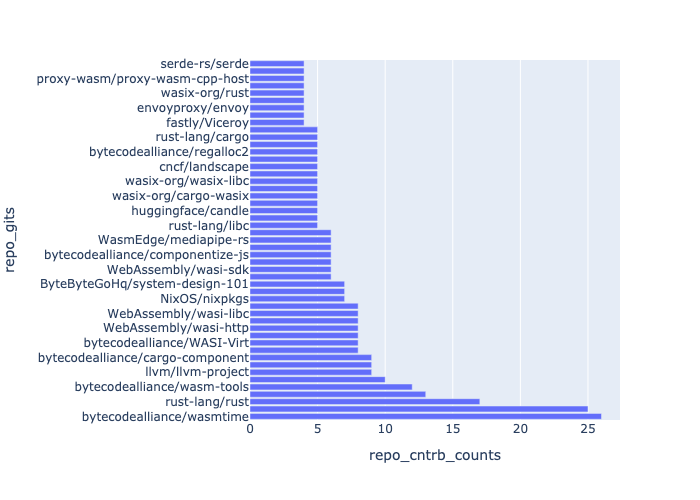

In [111]:
fig.write_image("repo_cntrb_counts.png")
Image(filename="repo_cntrb_counts.png")

In [114]:
# Here's the list of the top-50 most mutual repos among pagerank-top contributors
df_for_fig[:FINAL_NUM_COMMON_REPOS]

,repo_gits,repo_cntrb_counts
85,bytecodealliance/wasmtime,26
5,WasmEdge/WasmEdge,25
147,rust-lang/rust,17
75,bytecodealliance/meetings,13
99,bytecodealliance/wasm-tools,12
384,bytecodealliance/wit-bindgen,10
562,llvm/llvm-project,9
110,WebAssembly/component-model,9
82,bytecodealliance/cargo-component,9
681,wasmerio/wasmer,8




## Interpretation

We're expecting that the "repos of most significant mutual involvement" should include the seed projects because, by definition, we know that each of the\
contributors considered begins, in our analysis, as a past contributor to these projects.

However, we're not attempting a perfect retrospective analysis of contributor involvement- our dataset is of events going back only so far (approx. 6 mos at time of writing). \
Therefore, it's not surprising that (wavm/wavm) does NOT appear in the top-50 we generate here, unlike wasmtime, wasmedge, and wasmer. In the near past, it may not have the \
same traction it did when the resource that we used to identify seed projects was created.

These are useful results because they exhibit, at a glance, high WASM-specificity. With these top 50 projects, we are able to look "beyond" our initial seed projects, acknowledging \
highly mutual projects within this project space that we couldn't, without significant specialized knowledge, identify on our own.

## Next Steps

Set the 'seed' of another cycle of discovery to these 50 repos, called seed_1 (the successor to seed_0). Using this new, more inclusive seed_1, build a new collaboration network \
and rank the contributors in the new network. We infer that there will be significant overlap between those that are most involved in the seed_0 analysis phase as those identified \
in the seed_1 analysis phase. 

Re-run this analysis, producing a prospective seed_2. Repeat, eventually generating seed_n. When seed_(n-1) is sufficiently similar to seed_n, we'll conclude that the identified \
"neighborhood" of the final seed repos has converged.

As an interesting alternate thread, consider the use of pagerank-central contributors as done in this notebook. Instead of finding repos of largest mutuality, use the Events themselves \
with appropriate filtering to find those projects of highest sub-population involvement, at least numerically, and compare against this notebook. (/notebooks/project_discover/repo_discovery). \
Filtering currently in process to remove events associated with heuristically minimally interesting repos.

Having a set of repos we can confidently say are "highly mutual" at least, we can use network science to visualize the neighborhood connectome over time (notebooks/graph_analysis/approaches). \
